In [5]:
import pandas as pd #Must be using an older version of Pandas due to compatability issues with the anomaly detectors
import matplotlib.pyplot as plt
import numpy as np

#Anomaly detection:
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import PersistAD
'''Detector that detects anomaly based on values in a preceding period.

This detector compares time series values with the values of their preceding time windows,
and identifies a time point as anomalous if the change of value from its preceding average
 or median is anomalously large.
 '''

'Detector that detects anomaly based on values in a preceding period.\n\nThis detector compares time series values with the values of their preceding time windows,\nand identifies a time point as anomalous if the change of value from its preceding average\n or median is anomalously large.\n '

### Regional CBA account
NOTE: Be careful with values with monetary units. Time series analysis must be adjusted for inflation.

In [40]:
D_cba_reg = pd.read_csv('summary\D_cba_reg.csv',sep='\t',index_col=[0])

In [41]:
D_cba_reg_column_names = list(D_cba_reg.columns)
display(D_cba_reg_column_names[-12:-1]) #displaying compiled stressor columns

['Total CO2',
 'Total CH4',
 'Total N2O',
 'Total SOx',
 'Total PM10',
 'Total PM2.5',
 'Total Water Consumption Blue',
 'Total Domestic Extraction Used',
 'Total Land Use',
 'Value Added',
 'Total Employment Hours']

In [42]:
''' Making a list of the available regions: '''
regions_ALL = list(D_cba_reg.loc[:,'region'])
regions = list(set(regions_ALL))

Only the index-by-index classification is used for this study.

In [45]:
''' Industry by industry dataframe '''
D_cba_reg_ixi = D_cba_reg.loc[D_cba_reg['system'] == 'ixi']

Project work looked at the regions: The United States, the EU and Eastern Asia and Pacific (mostly dominated by China). Any region available in D_cba reg should be available by use of its region code.

Producing time-series Dataframes for equivalents of any region:

In [46]:
''' The function produces a dataframe of a region's stressors for the time frame available (1995-2022). '''
def time_series(cba, region):
    df = cba.loc[cba['region'] == region] #cba being either the pxp or ixi dataframe
    return df

In [47]:
#Global
D_cba_GLOBAL = time_series(D_cba_reg_ixi,'global')

#The United States:
D_cba_USA = time_series(D_cba_reg_ixi,'US')

#The EU
D_cba_EU27 = time_series(D_cba_reg_ixi,'EU27')

#China
D_cba_CHINA = time_series(D_cba_reg_ixi,'CN') #In exiobase CH is the code for Switzerland. CN is China!

In [48]:
#Normalization function, used throughout the analysis
def normalize(time_series, ref_point):
    return time_series/ref_point #ref point is supposed to be 1995

#### Anomaly detection setup:

In [49]:
#The detection package is depentant on DatetimeIndex, so years must be converted to that object type
global_co2 = D_cba_GLOBAL.loc[:,'Total CO2'].to_numpy()
date_time_years = pd.to_datetime(D_cba_GLOBAL.index, format='%Y')

In [51]:
#This is the module used for the anomaly detection
persist_ad = PersistAD(c=1) #c --> factor used to determine the bound of normal range based on historical interquartile range

Defining general anomaly detection plotters:

In [52]:
def detect_anomaly(impact):
    glob = pd.DataFrame(D_cba_GLOBAL.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', the World'])
    Usa = pd.DataFrame(D_cba_USA.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', USA'])
    Eu = pd.DataFrame(D_cba_EU27.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', EU27'])
    China = pd.DataFrame(D_cba_CHINA.loc[:,impact].to_numpy(),index=date_time_years,columns=[impact + ', China'])

    glob = validate_series(glob)
    Usa = validate_series(Usa)
    Eu = validate_series(Eu)
    China = validate_series(China)

    an_Global = persist_ad.fit_detect(glob).to_numpy()
    an_USA = persist_ad.fit_detect(Usa).to_numpy()
    an_Eu = persist_ad.fit_detect(Eu).to_numpy()
    an_China = persist_ad.fit_detect(China).to_numpy()

    an_Global = pd.DataFrame(an_Global, index=D_cba_GLOBAL.index, columns=['The World']).fillna(False)
    an_USA = pd.DataFrame(an_USA, index=D_cba_USA.index, columns=['USA']).fillna(False)
    an_Eu = pd.DataFrame(an_Eu, index=D_cba_EU27.index, columns=['EU27']).fillna(False)
    an_China = pd.DataFrame(an_China, index=D_cba_CHINA.index, columns=['China']).fillna(False)

    return an_Global, an_USA, an_Eu, an_China

In [53]:
#Function that returns the anomalies of a single time series.
def detect_anomaly_singular(exio_reg, impact):
    ts = pd.DataFrame(exio_reg.loc[:,impact].to_numpy(),index=date_time_years,columns=['Anomalies'])
    ts = validate_series(ts)
    an_ts = persist_ad.fit_detect(ts)
    return an_ts

First, detect anomalies and map out when they occur.

Second, determine the scale of the anomaly detected. Present data concisely.

In [54]:
#Detected anomalies are dataframes containing boolean values. 
#TRUE if an anomaly is detected & FALSE if no anomaly is present.
anom_co2global, anom_co2US, anom_co2EU, anom_co2China = detect_anomaly('Total CO2')
co2anoms = pd.concat([anom_co2global,anom_co2US,anom_co2EU,anom_co2China],axis=1)

anom_landglobal, anom_landUS, anom_landEU, anom_landChina = detect_anomaly('Total Land Use')
landanoms = pd.concat([anom_landglobal,anom_landUS,anom_landEU,anom_landChina],axis=1)

anom_wglobal, anom_wUS, anom_wEU, anom_wChina = detect_anomaly('Total Water Consumption Blue')
wateranoms = pd.concat([anom_wglobal,anom_wUS,anom_wEU,anom_wChina],axis=1)

anom_mglobal, anom_mUS, anom_mEU, anom_mChina = detect_anomaly('Total Domestic Extraction Used')
materialanoms = pd.concat([anom_mglobal,anom_mUS,anom_mEU,anom_mChina],axis=1)
#This is to export the anomalies to an Excel file so I can create a comparable anomaly table.
#Should stay commented out to preserve the Excel sheet
#because I want several sheets (mode a appends to an existing Excel file):
'''with pd.ExcelWriter('anomaly_table.xlsx', mode='a') as writer:
    co2anoms.to_excel(writer, sheet_name='CBA_CO2')
    landanoms.to_excel(writer, sheet_name='CBA_land')
    wateranoms.to_excel(writer, sheet_name='CBA_water')
    materialanoms.to_excel(writer, sheet_name='CBA_material')'''

"with pd.ExcelWriter('anomaly_table.xlsx', mode='a') as writer:\n    co2anoms.to_excel(writer, sheet_name='CBA_CO2')\n    landanoms.to_excel(writer, sheet_name='CBA_land')\n    wateranoms.to_excel(writer, sheet_name='CBA_water')\n    materialanoms.to_excel(writer, sheet_name='CBA_material')"

In [55]:
#Determining some measure of the scale of the effect.
def anomaly_scale(time_series):
    #This function takes in the time-series and its equivalent anomaly list
    #and creates another dataframe containing the scale of the anomaly
    time_series = validate_series(time_series)

    an_ts = persist_ad.fit_detect(time_series).to_numpy()
    dt_ts = time_series.diff().to_numpy()

    an_scales = pd.DataFrame(np.zeros(len(time_series)), index= date_time_years, columns=time_series.columns)

    for i in range(len(dt_ts)):
        if (an_ts[i] == True):
            an_scales.iloc[i] = dt_ts[i]
    
    return an_scales

In [56]:
def impact_an_scales(impact):
    glob = anomaly_scale(pd.DataFrame(D_cba_GLOBAL.loc[:,impact].to_numpy(),index=date_time_years,columns=['The World']))
    usa = anomaly_scale(pd.DataFrame(D_cba_USA.loc[:,impact].to_numpy(),index=date_time_years,columns=['USA']))
    eu27 = anomaly_scale(pd.DataFrame(D_cba_EU27.loc[:,impact].to_numpy(),index=date_time_years,columns=['EU27']))
    china = anomaly_scale(pd.DataFrame(D_cba_CHINA.loc[:,impact].to_numpy(),index=date_time_years,columns=['China']))

    combined = pd.concat([glob,usa,eu27,china], axis=1)

    return combined

CO2_an_scales = impact_an_scales('Total CO2')
land_an_scales = impact_an_scales('Total Land Use')
water_an_scales = impact_an_scales('Total Water Consumption Blue')
material_an_scales = impact_an_scales('Total Domestic Extraction Used')

In [57]:
'''with pd.ExcelWriter('anomaly_scales.xlsx', mode='a') as writer:
    CO2_an_scales.to_excel(writer, sheet_name='CBA_CO2')
    land_an_scales.to_excel(writer, sheet_name='CBA_land')
    water_an_scales.to_excel(writer, sheet_name='CBA_water')
    material_an_scales.to_excel(writer, sheet_name='CBA_material')'''

"with pd.ExcelWriter('anomaly_scales.xlsx', mode='a') as writer:\n    CO2_an_scales.to_excel(writer, sheet_name='CBA_CO2')\n    land_an_scales.to_excel(writer, sheet_name='CBA_land')\n    water_an_scales.to_excel(writer, sheet_name='CBA_water')\n    material_an_scales.to_excel(writer, sheet_name='CBA_material')"

The footprints that are primarily of interest are:
-  Global warming footprint
-  Water use footprint
-  Land use footprint
-  Material use footprint

General plot functions can be defined to make plotting data easier:

In [ ]:
'''
ADTK-toolkit has its own plotter, but it does not suit the methods of this study.
I want to plot several sets of anomalies on the same figure, so I have to make my own.
'''
years = D_cba_GLOBAL.index.to_numpy()
#Plot functions for anomalies:
def plot_anoms(impact, region, values):
    anoms = impact.loc[:,region].to_numpy()

    for i in range(len(years)):
        if anoms[i] == True:
            plt.plot(years[i], values.iloc[i], 'ro')

def plot_land_anoms(impact, region, values): #Land use gets its own function because of time-series length
    anoms = impact.loc[:,region].to_numpy()

    for i in range(len(years)-1):
        if anoms[i] == True:
            plt.plot(years[i], values.iloc[i], 'ro')

In [59]:
#Normalized plot function (to initial 1995 values)
def plot_norm_footprint(input, footprint, anoms, plot_title, color):
    norm = normalize(input.loc[:,footprint], input.loc[1995,footprint])

    #All 2022 rows have the value 0 for 'Total Land Use'. This makes clearer plots:
    if (footprint == 'Total Land Use'):
        norm = norm.iloc[:-1]

    norm.plot(title = plot_title, color=color)
    
    #Setting limits
    min_val = normalize(input.loc[:,footprint], input.loc[1995,footprint].min()).min()
    lower_lim = 0.9
    if (lower_lim >= min_val): #incase normalized values exceed predetermined lower limit
        lower_lim = min_val*0.9
    else:
        lower_lim = lower_lim    
    upper_lim = (normalize(input.loc[:,footprint], input.loc[1995,footprint]).max())*1.1

    #PLotting anomalies
    if (footprint == 'Total Land Use'):
        plot_land_anoms(anoms, 'The World', norm)
    else:
        plot_anoms(anoms, 'The World', norm)

    plt.ylim((lower_lim,upper_lim))

    plt.axvline(x=1997, color='lightgray', linestyle='--',label='Asian financial crisis')
    plt.axvline(x=2001, color='lightgray', linestyle='--',label='Dotcom bubble')
    plt.axvline(x=2007, color='lightgray', linestyle='--',label='Global financial crisis')
    plt.axvline(x=2020, color='lightgray', linestyle='--',label='COVID-19 pandemic')

    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = True

    plt.xlabel('year')

In [ ]:
#Normalized plot function (to initial 1995 values) to plot regional (USE, EU27 and China) impacts on same figure
#This function only plots for a single accounting perspective. The function for both acocunting perspectives are in another notebook.
def plot_norm_reg_footprint(footprint, anoms, plot_title):
    norm1 = normalize(D_cba_USA.loc[:,footprint], D_cba_USA.loc[1995,footprint])
    norm2 = normalize(D_cba_EU27.loc[:,footprint], D_cba_EU27.loc[1995,footprint])
    norm3 = normalize(D_cba_CHINA.loc[:,footprint], D_cba_CHINA.loc[1995,footprint])

    norm1 = norm1.rename('USA')
    norm2 = norm2.rename('EU27')
    norm3 = norm3.rename('China')

    #All 2022 rows have the value 0 for 'Total Land Use'. This makes clearer plots:
    if (footprint == 'Total Land Use'):
        norm1 = norm1.iloc[:-1]
        norm2 = norm2.iloc[:-1]
        norm3 = norm3.iloc[:-1]

    norm1.plot(title = plot_title, color='tab:green')
    norm2.plot(color='tab:orange')
    norm3.plot(color='tab:blue')

    #Plotting anomalies
    if (footprint == 'Total Land Use'):
        plot_land_anoms(anoms, 'USA', norm1)
        plot_land_anoms(anoms, 'EU27', norm2)
        plot_land_anoms(anoms, 'China', norm3)
    else:
        plot_anoms(anoms, 'USA', norm1)
        plot_anoms(anoms, 'EU27', norm2)
        plot_anoms(anoms, 'China', norm3)

    plt.legend()

    plt.axvline(x=1997, color='lightgray', linestyle='--',label='Asian financial crisis')
    plt.axvline(x=2001, color='lightgray', linestyle='--',label='Dotcom bubble')
    plt.axvline(x=2007, color='lightgray', linestyle='--',label='Global financial crisis')
    plt.axvline(x=2020, color='lightgray', linestyle='--',label='COVID-19 pandemic')

    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = True

    plt.xlabel('year')

### Plotting for <span style='color:red'> Global warming footprint</span>: 
(just CO2 emissions)
This file only plots the global accounts. Regional accounts, for both perspectives are found in another file.

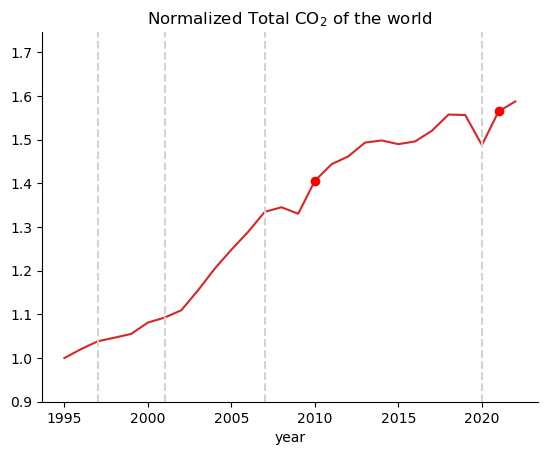

In [61]:
plot_norm_footprint(D_cba_GLOBAL, 'Total CO2', co2anoms, 'Normalized Total CO$_2$ of the world', 'tab:red')
plt.savefig('time_series_plots/WorldCO2norm')

### Plotting for <span style='color:red'> Global land use footprint </span>:

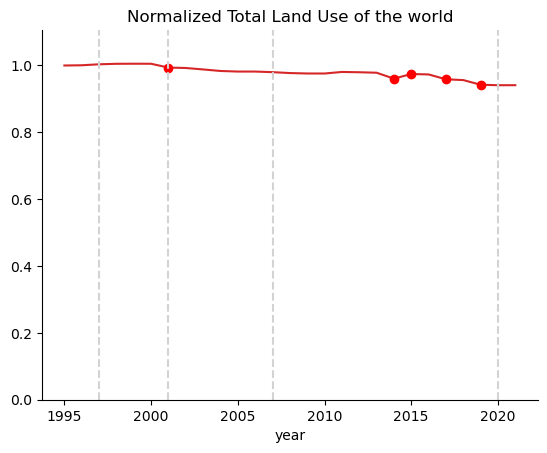

In [32]:
plot_norm_footprint(D_cba_GLOBAL, 'Total Land Use', landanoms, 'Normalized Total Land Use of the world', 'tab:red')
plt.savefig('time_series_plots/worldLandUsenorm')

### Plotting for <span style='color:red'> Global water use footprint </span>:

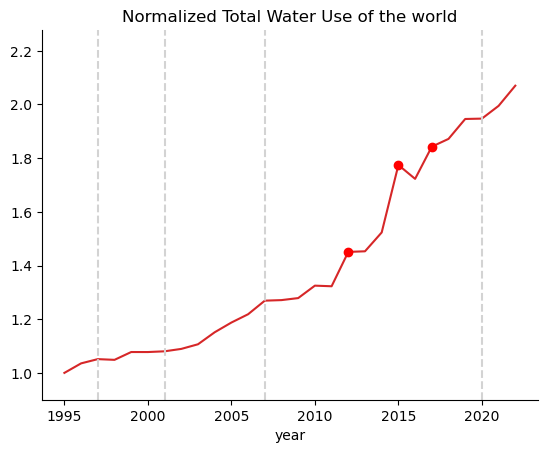

In [34]:
plot_norm_footprint(D_cba_GLOBAL, 'Total Water Consumption Blue', wateranoms, 'Normalized Total Water Use of the world', 'tab:red')
plt.savefig('time_series_plots/worldWaterUsenorm')

### Plotting for <span style='color:red'> Global material use footprint </span>:

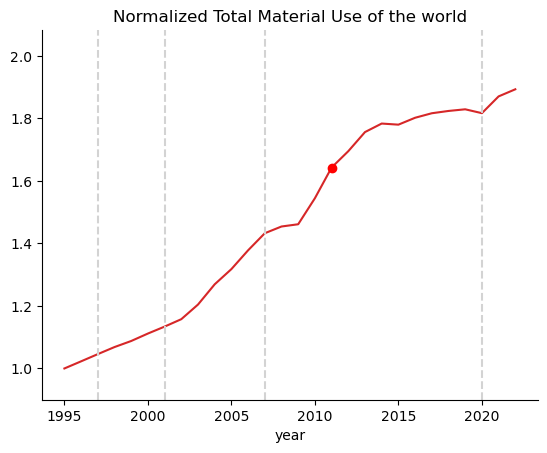

In [37]:
plot_norm_footprint(D_cba_GLOBAL, 'Total Domestic Extraction Used', materialanoms, 'Normalized Total Material Use of the world', 'tab:red')
plt.savefig('time_series_plots/worldMaterialUsenorm')